<a href="https://colab.research.google.com/github/Leafmun-certii/complimentory-protein-caculator/blob/main/complimentory_protein_caculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#@title # Protein Complementarity Calculator
# Finding Optimal Combinations of Incomplete Proteins

!pip install pandas numpy matplotlib seaborn scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [17]:
#@title ## 1. Amino Acid Reference Pattern (WHO/FAO 2013)

# Essential amino acid requirements (mg/g protein) for adults
reference_pattern = {
    'Histidine': 18,
    'Isoleucine': 25,
    'Leucine': 59,
    'Lysine': 45,
    'Methionine_Cysteine': 22,  # Combined sulfur amino acids
    'Phenylalanine_Tyrosine': 38,  # Combined aromatic amino acids
    'Threonine': 23,
    'Tryptophan': 6,
    'Valine': 39
}

print("WHO/FAO Reference Pattern (mg/g protein):")
for aa, value in reference_pattern.items():
    print(f"{aa:<25}: {value:>3} mg/g")


WHO/FAO Reference Pattern (mg/g protein):
Histidine                :  18 mg/g
Isoleucine               :  25 mg/g
Leucine                  :  59 mg/g
Lysine                   :  45 mg/g
Methionine_Cysteine      :  22 mg/g
Phenylalanine_Tyrosine   :  38 mg/g
Threonine                :  23 mg/g
Tryptophan               :   6 mg/g
Valine                   :  39 mg/g


In [12]:
#@title ## 2. Amino Acid Profiles of Common Proteins

# Amino acid content (mg/g protein) - based on USDA data
protein_profiles = {
    'Rice': {
        'Histidine': 23, 'Isoleucine': 33, 'Leucine': 66, 'Lysine': 29,  # Low lysine!
        'Methionine_Cysteine': 35, 'Phenylalanine_Tyrosine': 51,
        'Threonine': 28, 'Tryptophan': 9, 'Valine': 46
    },
    'Beans': {
        'Histidine': 30, 'Isoleucine': 42, 'Leucine': 71, 'Lysine': 63,  # High lysine!
        'Methionine_Cysteine': 15, 'Phenylalanine_Tyrosine': 49,  # Low methionine!
        'Threonine': 38, 'Tryptophan': 10, 'Valine': 48
    },
    'Corn': {
        'Histidine': 26, 'Isoleucine': 28, 'Leucine': 95, 'Lysine': 21,  # Very low lysine!
        'Methionine_Cysteine': 40, 'Phenylalanine_Tyrosine': 72,
        'Threonine': 30, 'Tryptophan': 4, 'Valine': 38  # Low tryptophan!
    },
    'Peanuts': {
        'Histidine': 24, 'Isoleucine': 35, 'Leucine': 63, 'Lysine': 32,  # Low lysine
        'Methionine_Cysteine': 25, 'Phenylalanine_Tyrosine': 95,
        'Threonine': 24, 'Tryptophan': 11, 'Valine': 43
    },
    'Quinoa': {
        'Histidine': 31, 'Isoleucine': 42, 'Leucine': 68, 'Lysine': 51,  # Good lysine!
        'Methionine_Cysteine': 28, 'Phenylalanine_Tyrosine': 69,
        'Threonine': 38, 'Tryptophan': 13, 'Valine': 46
    },
    'Lentils': {
        'Histidine': 31, 'Isoleucine': 45, 'Leucine': 73, 'Lysine': 69,  # High lysine!
        'Methionine_Cysteine': 9, 'Phenylalanine_Tyrosine': 53,  # Very low methionine!
        'Threonine': 36, 'Tryptophan': 9, 'Valine': 49
    },
    'Seitan': { # Vital wheat gluten
        'Histidine': 18, 'Isoleucine': 33, 'Leucine': 67, 'Lysine': 17, # Very low lysine!
        'Methionine_Cysteine': 34, 'Phenylalanine_Tyrosine': 55,
        'Threonine': 29, 'Tryptophan': 10, 'Valine': 44
    },
    'Oats': {
        'Histidine': 24, 'Isoleucine': 40, 'Leucine': 71, 'Lysine': 35, # Lower lysine
        'Methionine_Cysteine': 18, 'Phenylalanine_Tyrosine': 70,
        'Threonine': 34, 'Tryptophan': 12, 'Valine': 48
    },
    'Buckwheat': {
        'Histidine': 23, 'Isoleucine': 42, 'Leucine': 69, 'Lysine': 58, # Good lysine
        'Methionine_Cysteine': 29, 'Phenylalanine_Tyrosine': 87,
        'Threonine': 37, 'Tryptophan': 13, 'Valine': 51
    },
    'Green Peas': { # Whole green garden peas - based on USDA data
        'Histidine': 25, 'Isoleucine': 41, 'Leucine': 70, 'Lysine': 67, # Good lysine!
        'Methionine_Cysteine': 15, 'Phenylalanine_Tyrosine': 58, # Low methionine!
        'Threonine': 36, 'Tryptophan': 9, 'Valine': 47
    }
}


# Convert to DataFrame for easier analysis
df_proteins = pd.DataFrame(protein_profiles).T
df_reference = pd.Series(reference_pattern)

print("\nAmino Acid Profiles (mg/g protein):")
print(df_proteins)


Amino Acid Profiles (mg/g protein):
            Histidine  Isoleucine  Leucine  Lysine  Methionine_Cysteine  \
Rice               23          33       66      29                   35   
Beans              30          42       71      63                   15   
Corn               26          28       95      21                   40   
Peanuts            24          35       63      32                   25   
Quinoa             31          42       68      51                   28   
Lentils            31          45       73      69                    9   
Seitan             18          33       67      17                   34   
Oats               24          40       71      35                   18   
Buckwheat          23          42       69      58                   29   
Green Peas         25          41       70      67                   15   

            Phenylalanine_Tyrosine  Threonine  Tryptophan  Valine  
Rice                            51         28           9      46  
B

In [13]:
#@title ## 3. Calculate Amino Acid Scores
def calculate_amino_acid_scores(protein_profile, reference):
    """Calculate amino acid score for each essential amino acid"""
    scores = {}
    for aa in reference.index:
        if aa in protein_profile.index:
            scores[aa] = (protein_profile[aa] / reference[aa]) * 100
        else:
            scores[aa] = 0
    return pd.Series(scores)

def get_limiting_amino_acid(scores):
    """Find the limiting amino acid (lowest score)"""
    limiting_aa = scores.idxmin()
    limiting_score = scores.min()
    return limiting_aa, limiting_score

# Calculate scores for all proteins
protein_scores = {}
limiting_amino_acids = {}

print("\n" + "="*60)
print("AMINO ACID SCORES (% of requirement met)")
print("="*60)

for protein in df_proteins.index:
    scores = calculate_amino_acid_scores(df_proteins.loc[protein], df_reference)
    protein_scores[protein] = scores
    limiting_aa, limiting_score = get_limiting_amino_acid(scores)
    limiting_amino_acids[protein] = (limiting_aa, limiting_score)

    print(f"\n{protein}:")
    for aa, score in scores.items():
        marker = " ←UNDER  " if score < 100 else ""
        marker += " ←LIMITING" if aa == limiting_aa else ""
        print(f"  {aa:<25}: {score:>6.1f}%{marker}")
    print(f"  Overall Score (PDCAAS): {limiting_score:.1f}%")



AMINO ACID SCORES (% of requirement met)

Rice:
  Histidine                :  127.8%
  Isoleucine               :  132.0%
  Leucine                  :  111.9%
  Lysine                   :   64.4% ←UNDER   ←LIMITING
  Methionine_Cysteine      :  159.1%
  Phenylalanine_Tyrosine   :  134.2%
  Threonine                :  121.7%
  Tryptophan               :  150.0%
  Valine                   :  117.9%
  Overall Score (PDCAAS): 64.4%

Beans:
  Histidine                :  166.7%
  Isoleucine               :  168.0%
  Leucine                  :  120.3%
  Lysine                   :  140.0%
  Methionine_Cysteine      :   68.2% ←UNDER   ←LIMITING
  Phenylalanine_Tyrosine   :  128.9%
  Threonine                :  165.2%
  Tryptophan               :  166.7%
  Valine                   :  123.1%
  Overall Score (PDCAAS): 68.2%

Corn:
  Histidine                :  144.4%
  Isoleucine               :  112.0%
  Leucine                  :  161.0%
  Lysine                   :   46.7% ←UNDER   ←LIMITING
 

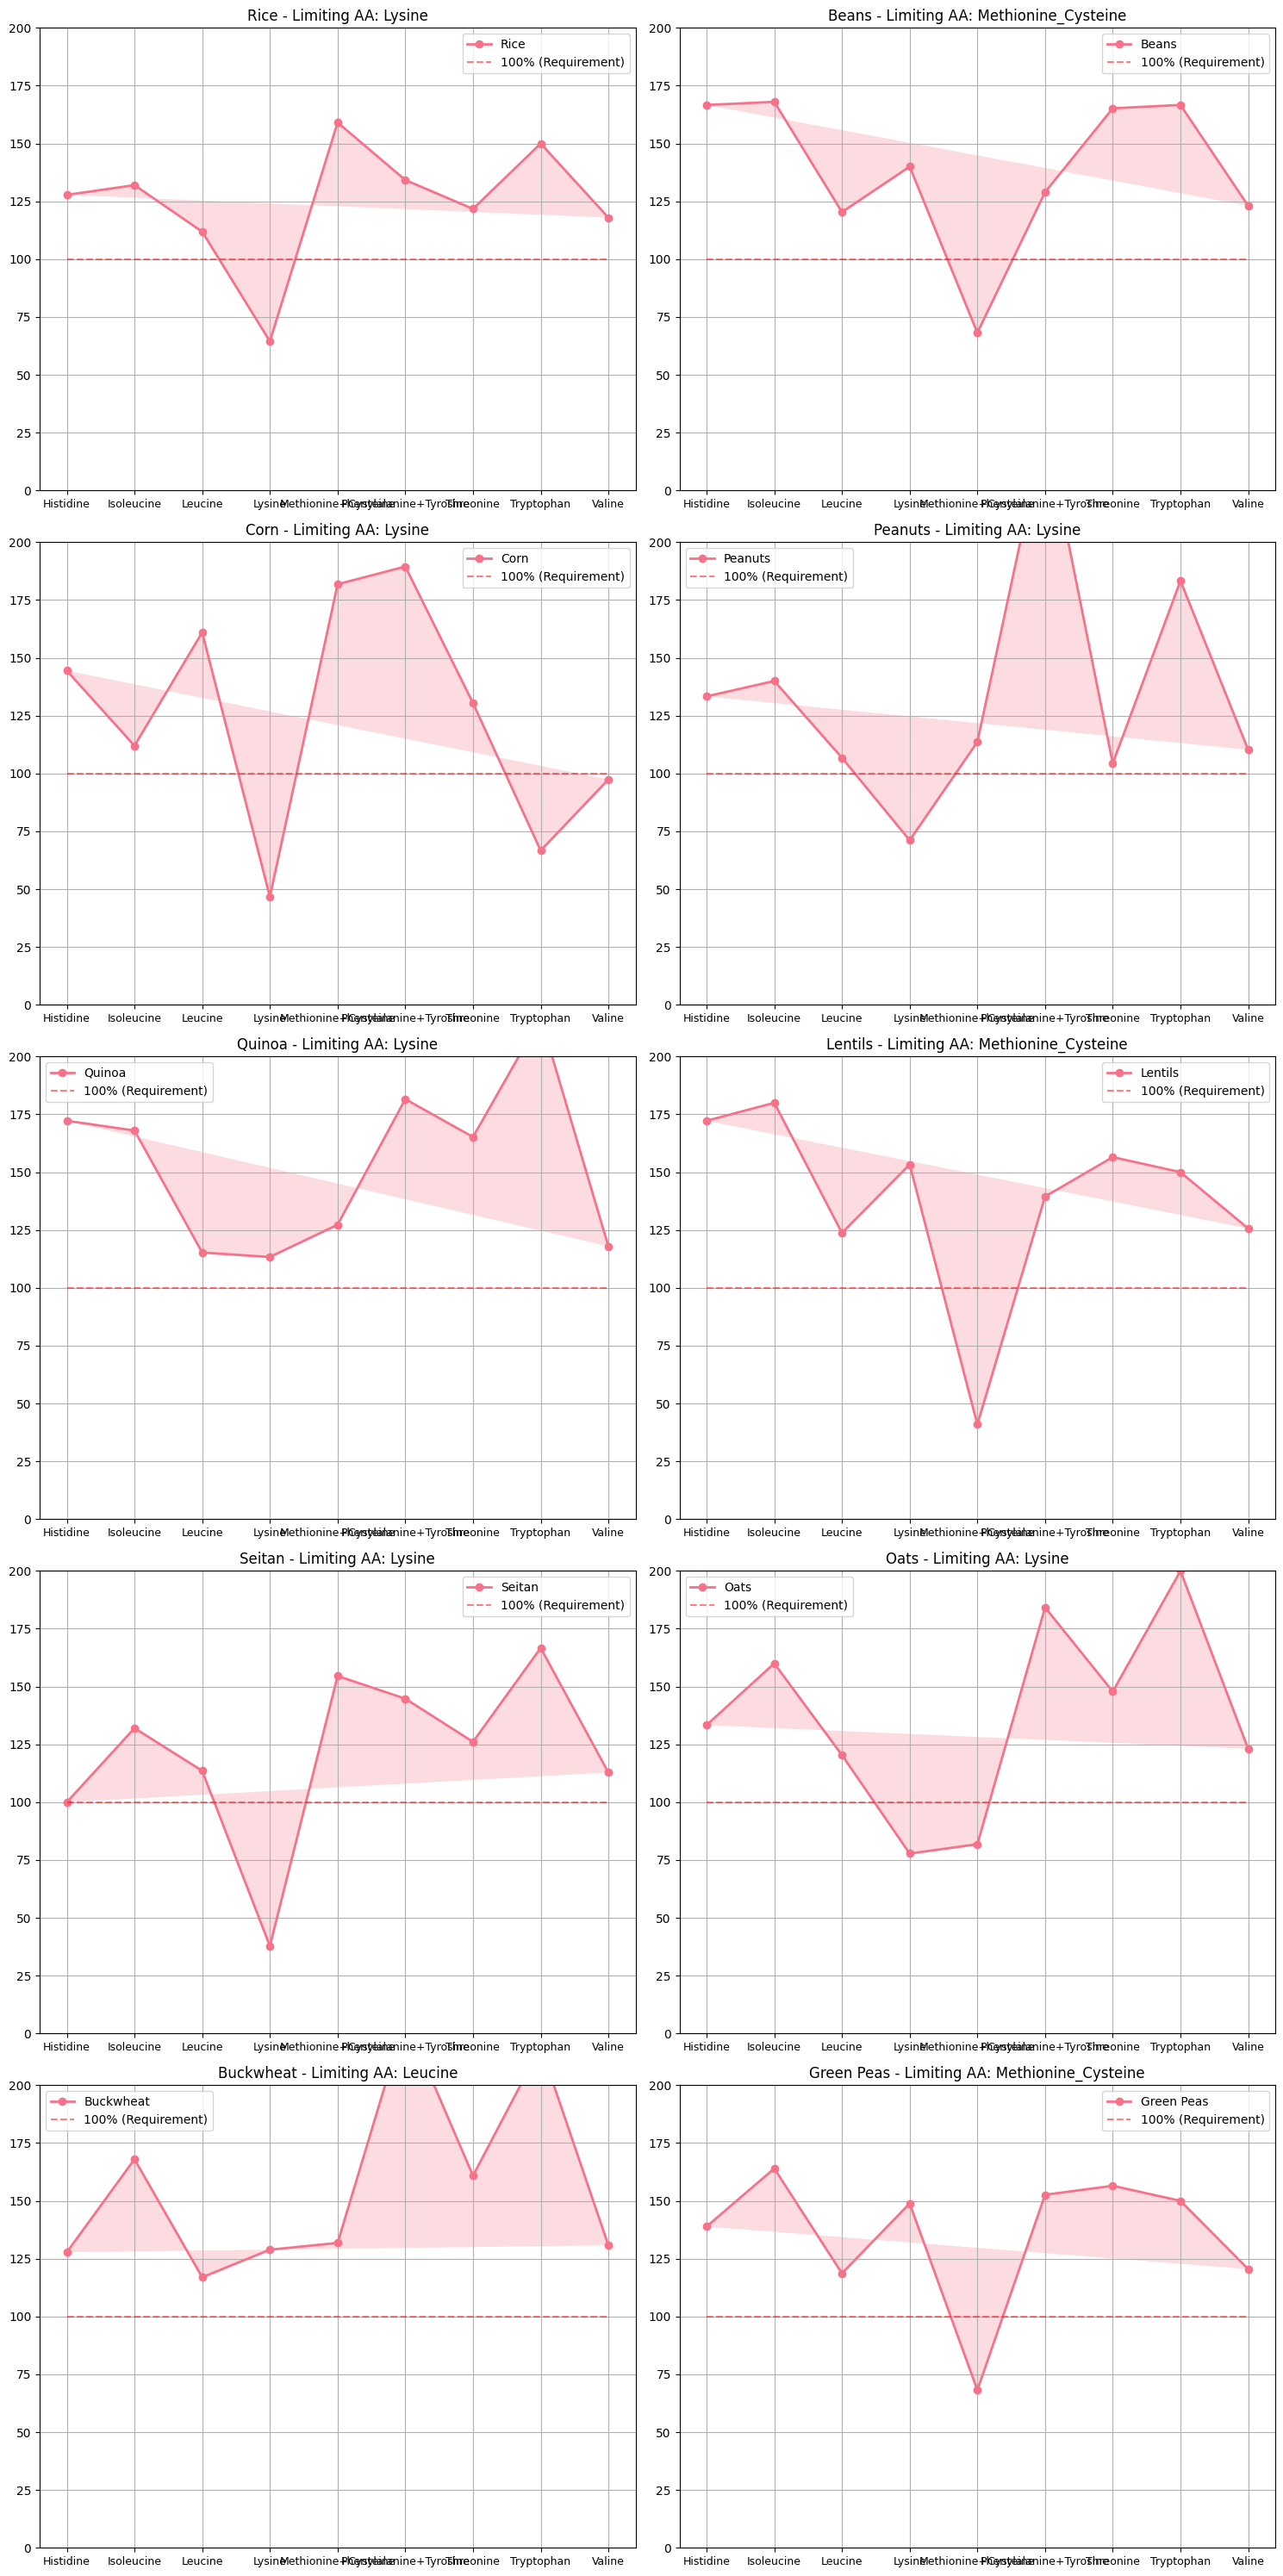

In [14]:
#@title ## 4. Visualization of Amino Acid Profiles

def plot_amino_acid_profiles(proteins_to_plot):
    """Create radar chart comparing amino acid profiles"""
    num_proteins = len(proteins_to_plot)
    rows = (num_proteins + 1) // 2  # Calculate number of rows needed (round up)
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6)) # Adjust figure size based on number of rows
    axes = axes.ravel()

    amino_acids = list(reference_pattern.keys())
    angles = np.linspace(0, 2*np.pi, len(amino_acids), endpoint=False).tolist()


    for idx, protein in enumerate(proteins_to_plot):
        ax = axes[idx]

        # Get scores for this protein
        scores = protein_scores[protein].values.tolist()


        # Plot
        ax.plot(angles, scores, 'o-', linewidth=2, label=protein)
        ax.fill(angles, scores, alpha=0.25)
        ax.plot(angles, [100]*len(angles), 'r--', alpha=0.5, label='100% (Requirement)')

        # Customize
        ax.set_xticks(angles)
        ax.set_xticklabels([aa.replace('_', '+') for aa in amino_acids], fontsize=9)
        ax.set_ylim(0, 200)
        ax.set_title(f'{protein} - Limiting AA: {limiting_amino_acids[protein][0]}', fontsize=12)
        ax.grid(True)
        ax.legend()

    # Hide any unused subplots
    for i in range(num_proteins, rows * cols):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()

plot_amino_acid_profiles(list(protein_profiles.keys()))

In [15]:
#@title ## 5. Find Complementary Protein Pairs

def find_complementary_pairs_optimized():
    """Identify which proteins complement each other well based on optimized combination score"""
    complementary_pairs = []

    proteins = list(protein_profiles.keys())

    print("\nCalculating optimal combinations for all pairs...")

    for i, protein1 in enumerate(proteins):
        for protein2 in proteins[i+1:]:

            # Start of optimize_protein_combination logic
            # Define the objective function (to minimize)
            def objective(ratios):
                ratio1, ratio2 = ratios
                # Ensure ratios sum to 1 (within tolerance)
                if abs(ratio1 + ratio2 - 1.0) > 1e-6:
                    return np.inf

                combined_scores = []
                for aa in df_reference.index:
                    combined_content = (ratio1 * df_proteins.loc[protein1, aa] +
                                      ratio2 * df_proteins.loc[protein2, aa])
                    combined_score = (combined_content / df_reference[aa]) * 100
                    combined_scores.append(combined_score)

                # We want to maximize the minimum score (PDCAAS), so we minimize the negative of the minimum score
                return -min(combined_scores)

            # Initial guess for ratios (equal parts)
            initial_ratios = [0.5, 0.5]

            # Define constraints and bounds
            # Ratios must be non-negative and sum to 1
            constraints = ({'type': 'eq', 'fun': lambda ratios: ratios[0] + ratios[1] - 1})
            bounds = ((0, 1), (0, 1)) # Ratios must be between 0 and 1

            # Perform the optimization
            result = minimize(objective, initial_ratios, method='SLSQP',
                              constraints=constraints, bounds=bounds)

            # Extract optimal ratios and the resulting optimal score (PDCAAS)
            optimal_ratio1, optimal_ratio2 = result.x
            optimal_score = -result.fun # Convert back to positive score

            # End of optimize_protein_combination logic


            # Get individual PDCAAS scores
            individual_score1 = limiting_amino_acids[protein1][1]
            individual_score2 = limiting_amino_acids[protein2][1]


            complementary_pairs.append({
                'Protein1': protein1,
                'Protein2': protein2,
                'Optimal Ratio 1': optimal_ratio1,
                'Optimal Ratio 2': optimal_ratio2,
                'Optimized Combined Score (PDCAAS)': optimal_score,
                'Individual PDCAAS 1': individual_score1,
                'Individual PDCAAS 2': individual_score2
            })


    df_complementary = pd.DataFrame(complementary_pairs).sort_values('Optimized Combined Score (PDCAAS)', ascending=False)

    # Filter out combinations where one protein is more than 90% of the mix
    filtered_df = df_complementary[
        (df_complementary['Optimal Ratio 1'] <= 0.9) &
        (df_complementary['Optimal Ratio 2'] <= 0.9)
    ].reset_index(drop=True)

    # Filter out combinations that don't have a better PDCAAS than either uncombined protein
    filtered_df = filtered_df[
        (filtered_df['Optimized Combined Score (PDCAAS)'] > filtered_df['Individual PDCAAS 1']) &
        (filtered_df['Optimized Combined Score (PDCAAS)'] > filtered_df['Individual PDCAAS 2'])
    ].reset_index(drop=True)


    return filtered_df

complementary_df_optimized = find_complementary_pairs_optimized()

print("\n" + "="*60)
print("OPTIMIZED PROTEIN COMPLEMENTARITY ANALYSIS (Filtered)")
print("="*60)
print("(Combinations with one protein > 90% excluded)")
print("(Only combinations with improved PDCAAS included)")
print("(Higher Optimized Combined Score = better combination)")
print(complementary_df_optimized)


Calculating optimal combinations for all pairs...

OPTIMIZED PROTEIN COMPLEMENTARITY ANALYSIS (Filtered)
(Combinations with one protein > 90% excluded)
(Only combinations with improved PDCAAS included)
(Higher Optimized Combined Score = better combination)
     Protein1    Protein2  Optimal Ratio 1  Optimal Ratio 2  \
0     Lentils   Buckwheat         0.152208         0.847792   
1       Beans   Buckwheat         0.221839         0.778161   
2        Oats   Buckwheat         0.219074         0.780926   
3   Buckwheat  Green Peas         0.772406         0.227594   
4      Quinoa     Lentils         0.873274         0.126726   
5       Beans      Quinoa         0.187273         0.812727   
6      Quinoa  Green Peas         0.807645         0.192355   
7        Corn  Green Peas         0.373889         0.626111   
8        Rice  Green Peas         0.460253         0.539747   
9       Beans        Corn         0.653001         0.346999   
10       Rice       Beans         0.431432       


VISUALIZING EAA PROFILES OF EACH OPTIMIZED COMBINATION


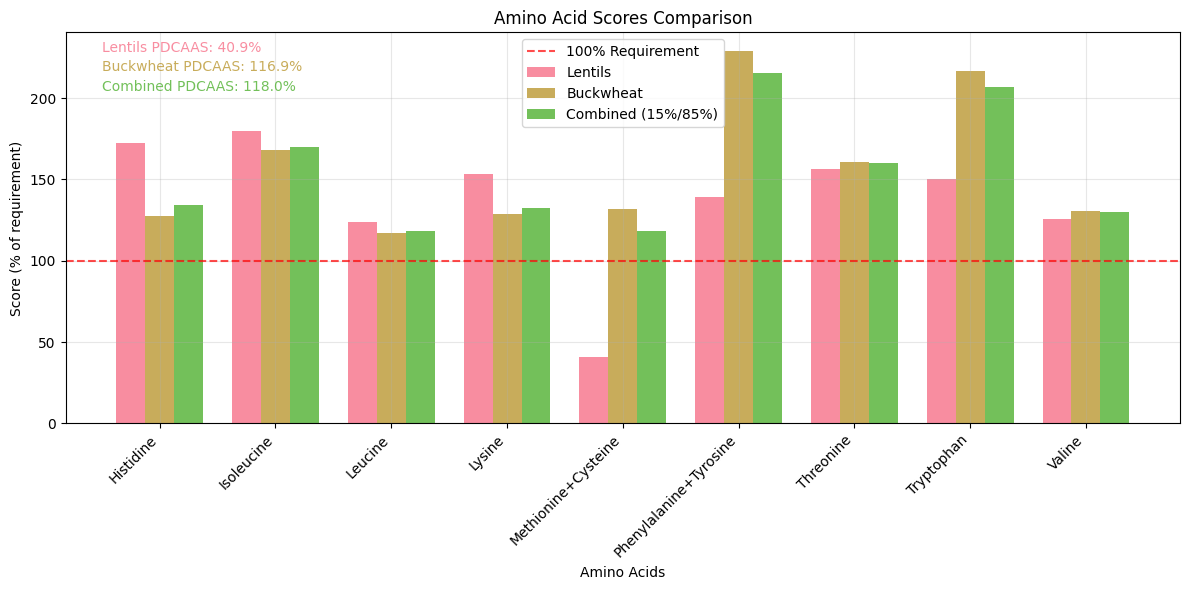

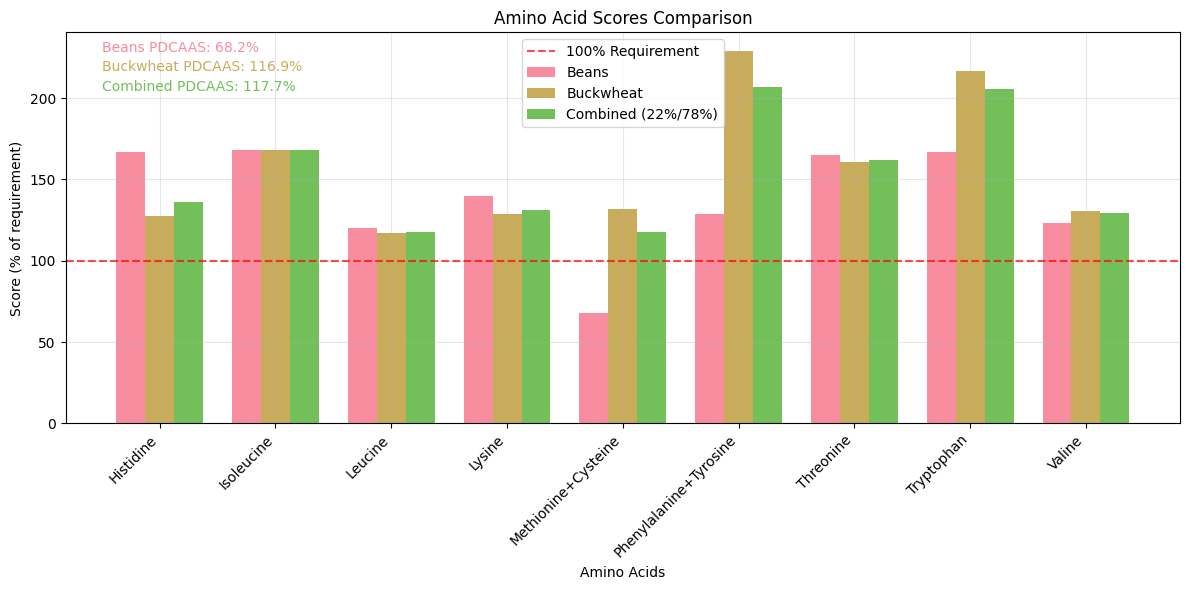

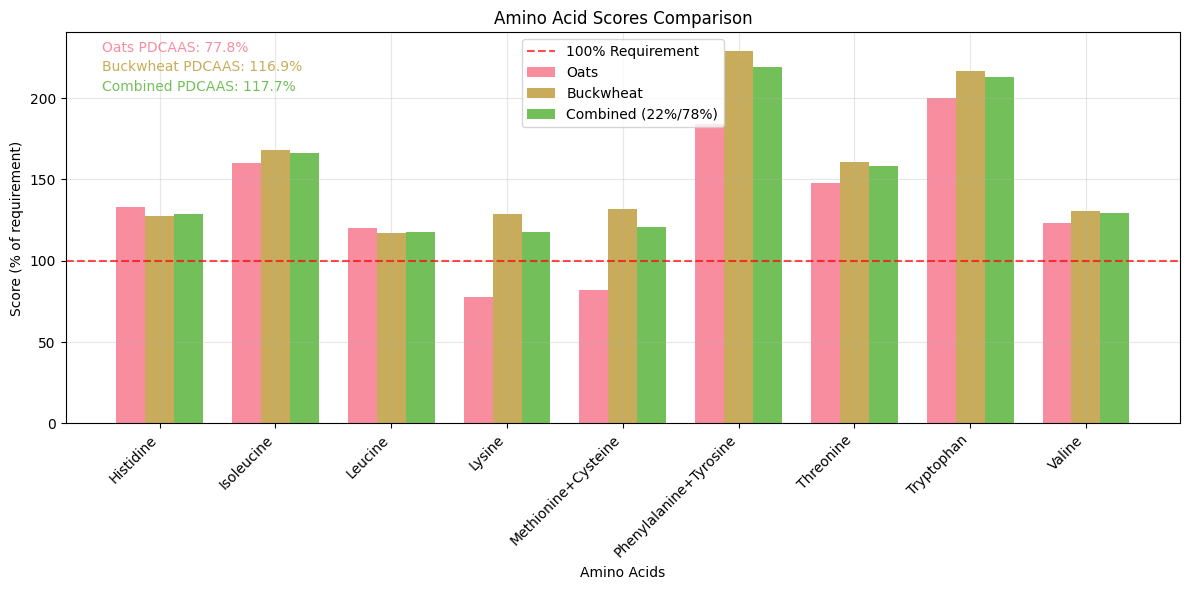

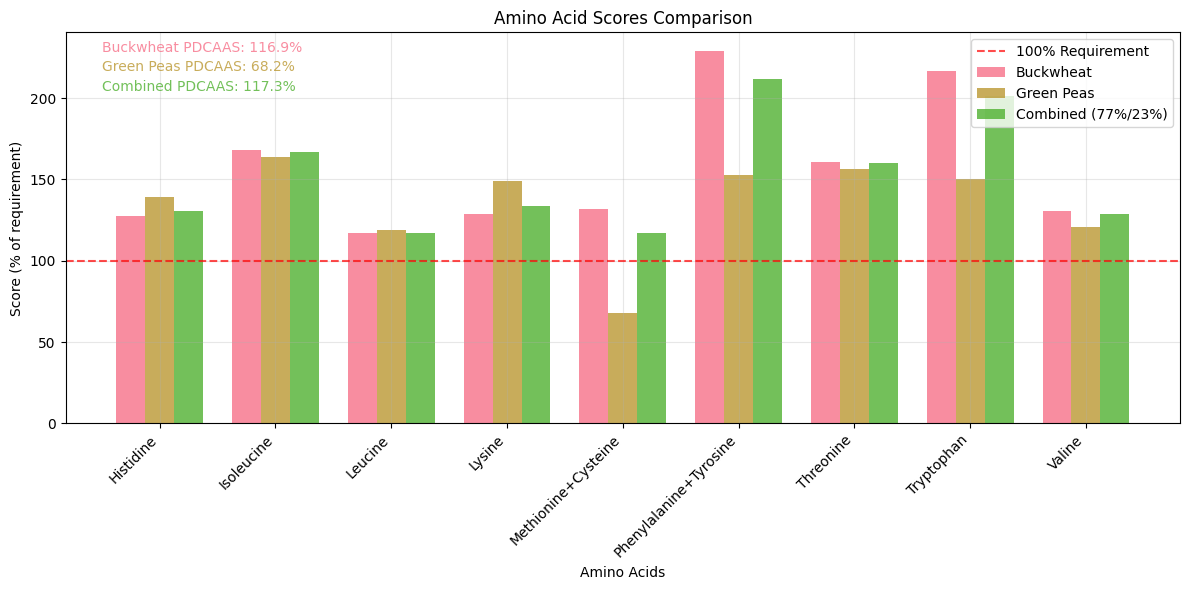

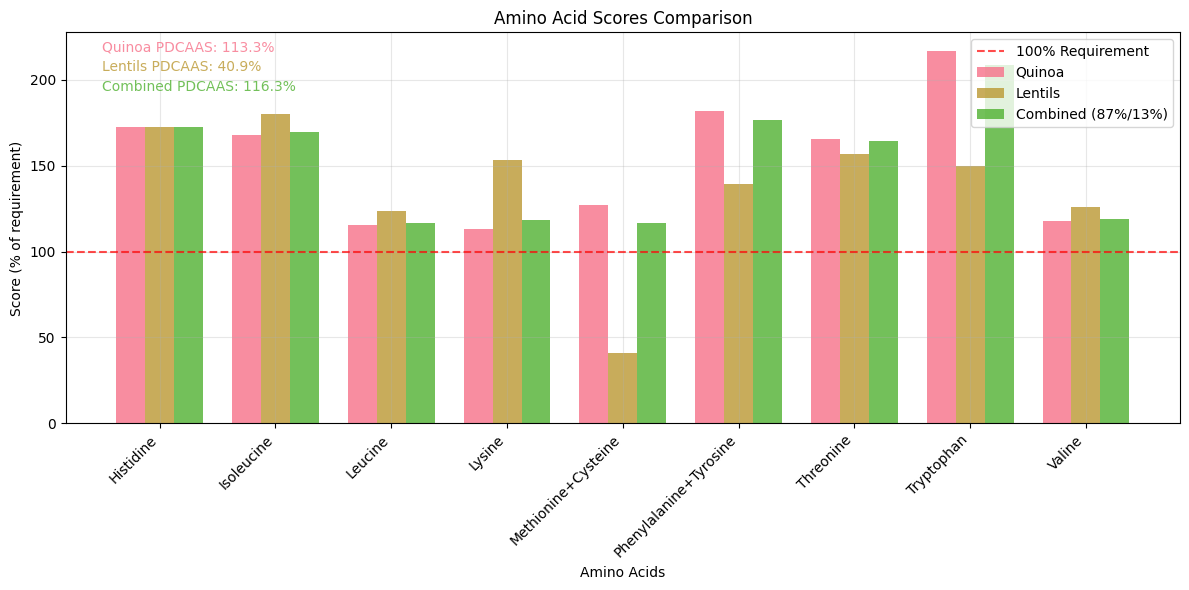

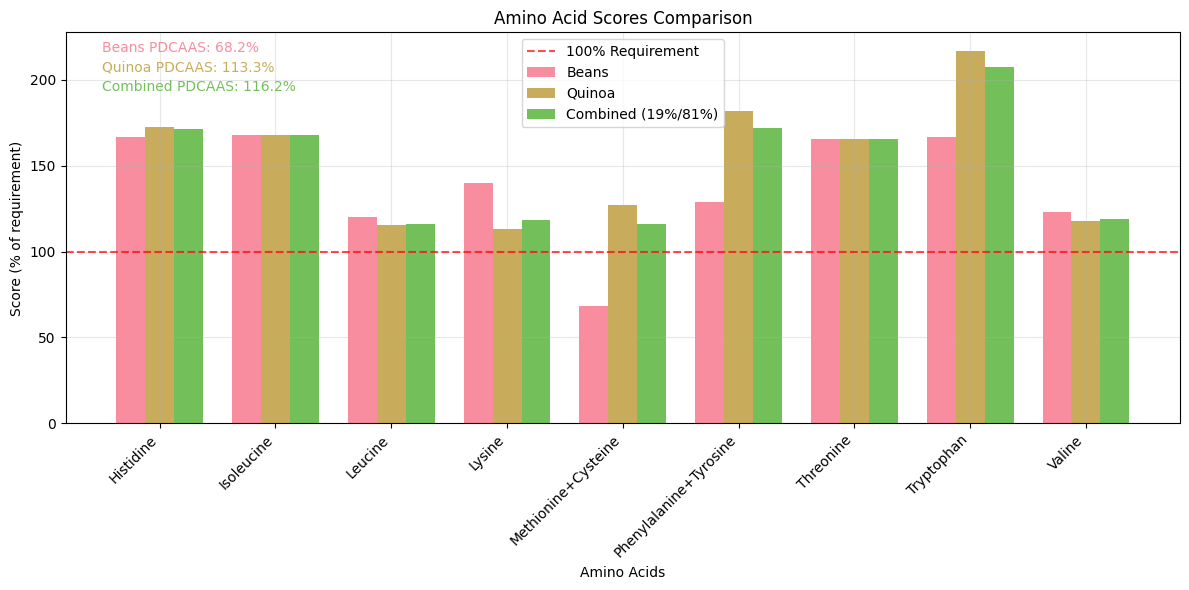

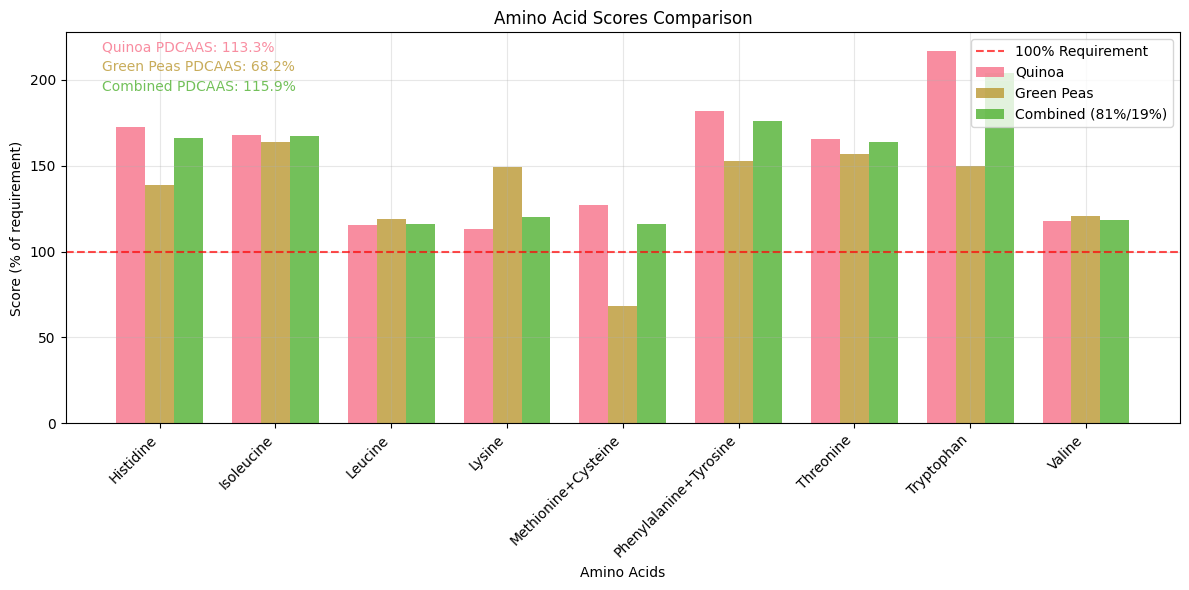

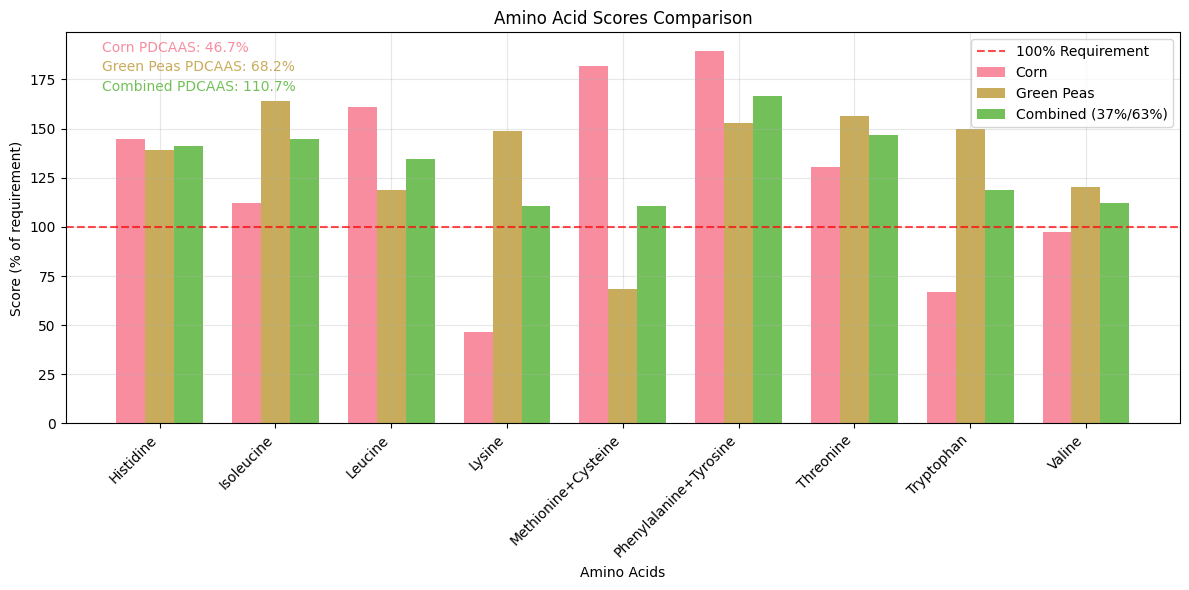

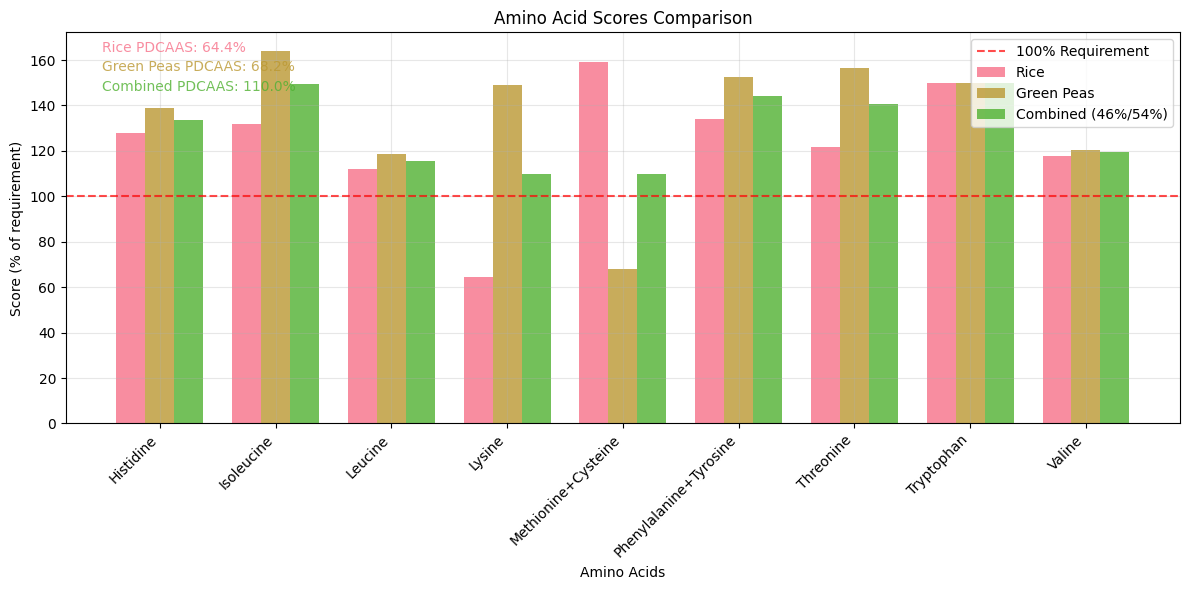

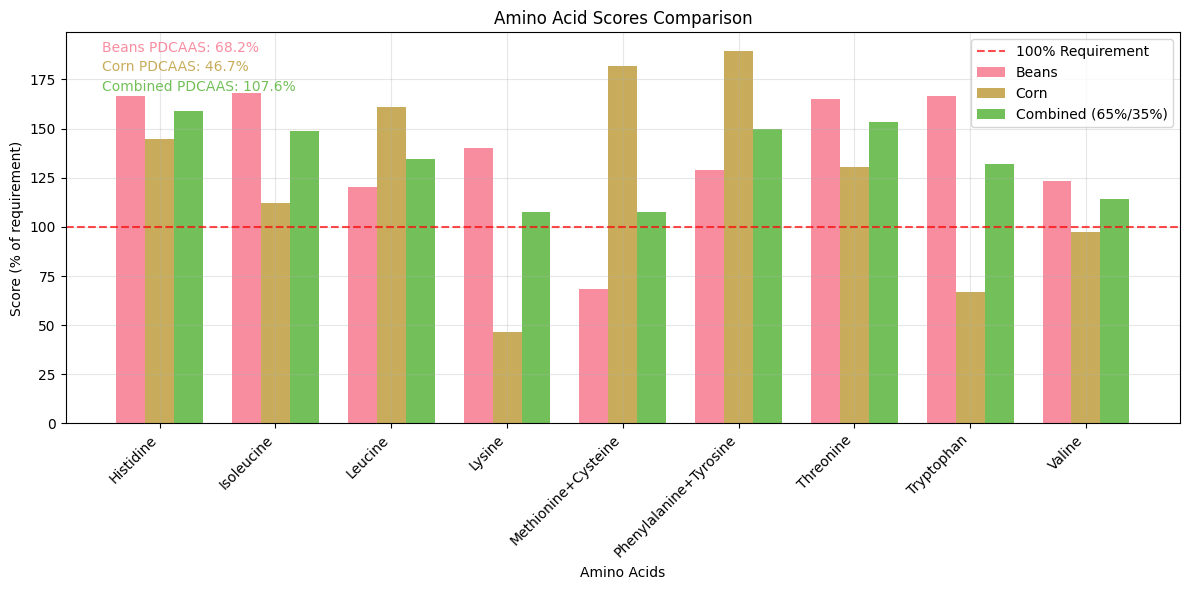

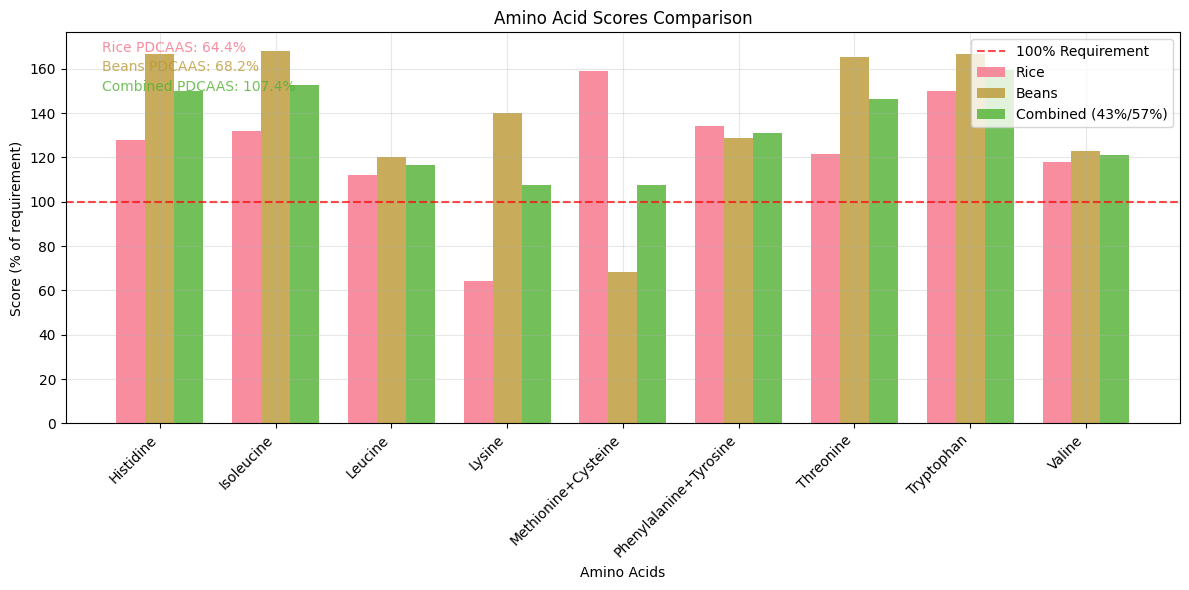

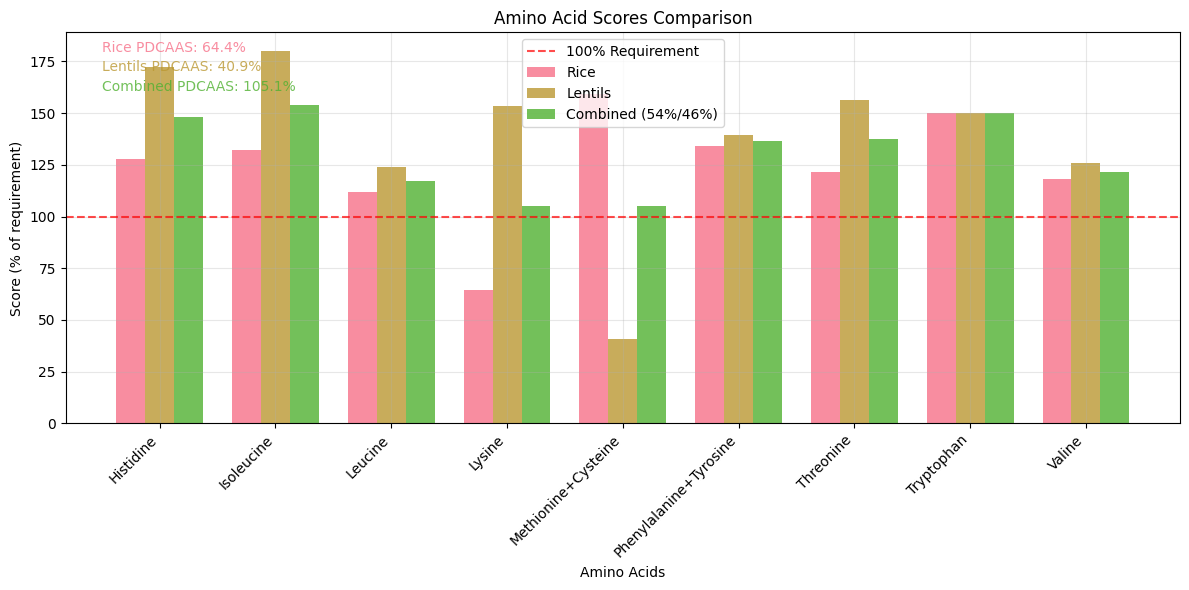

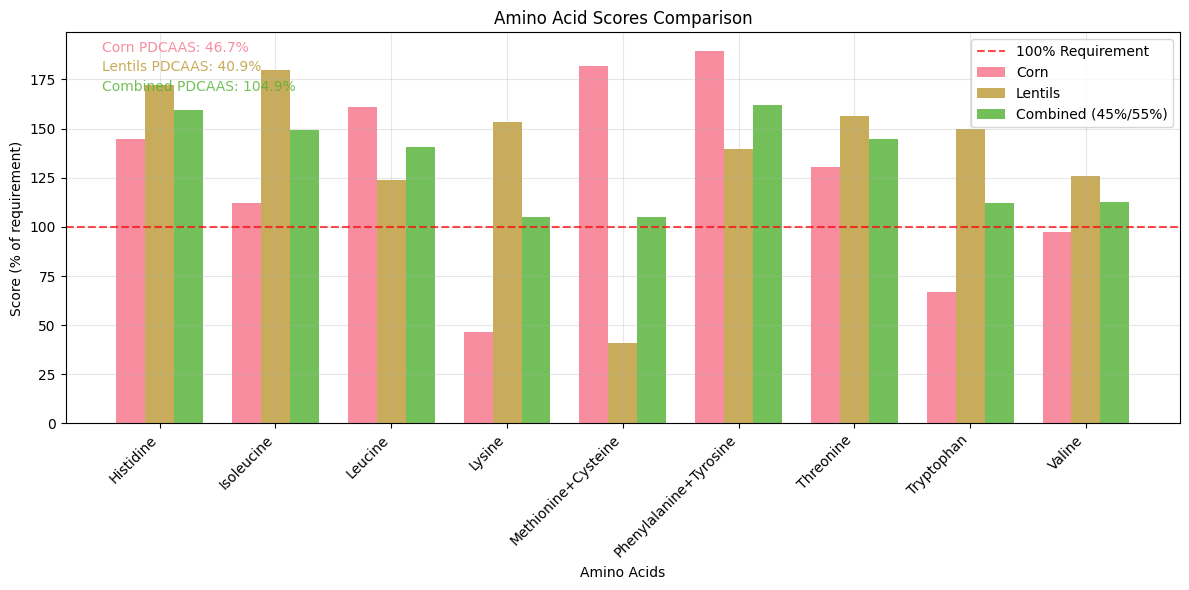

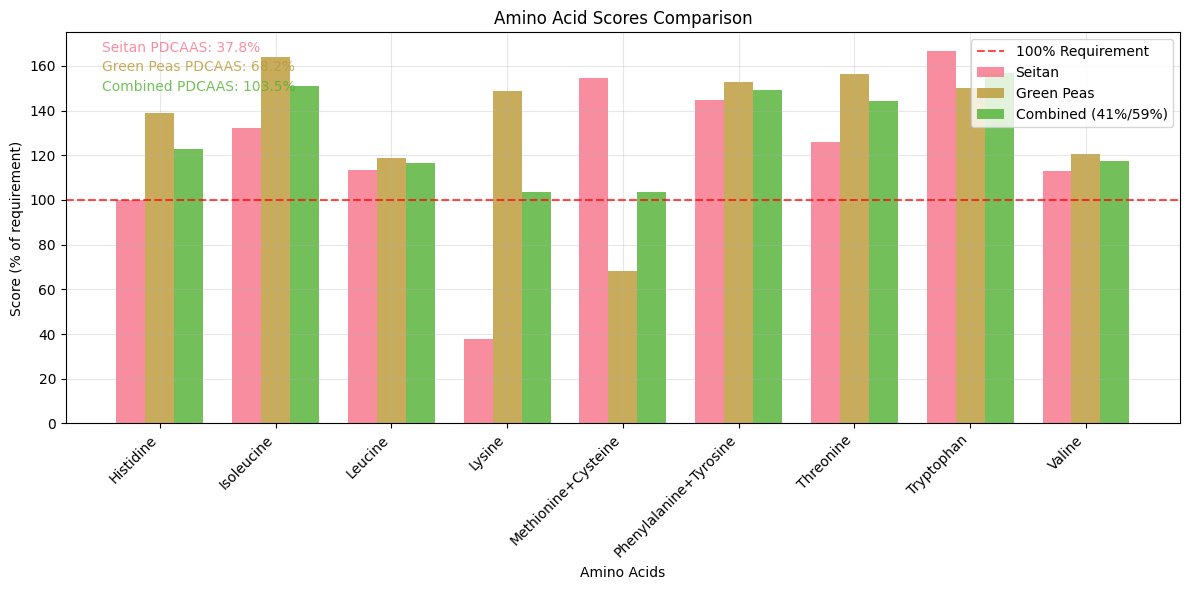

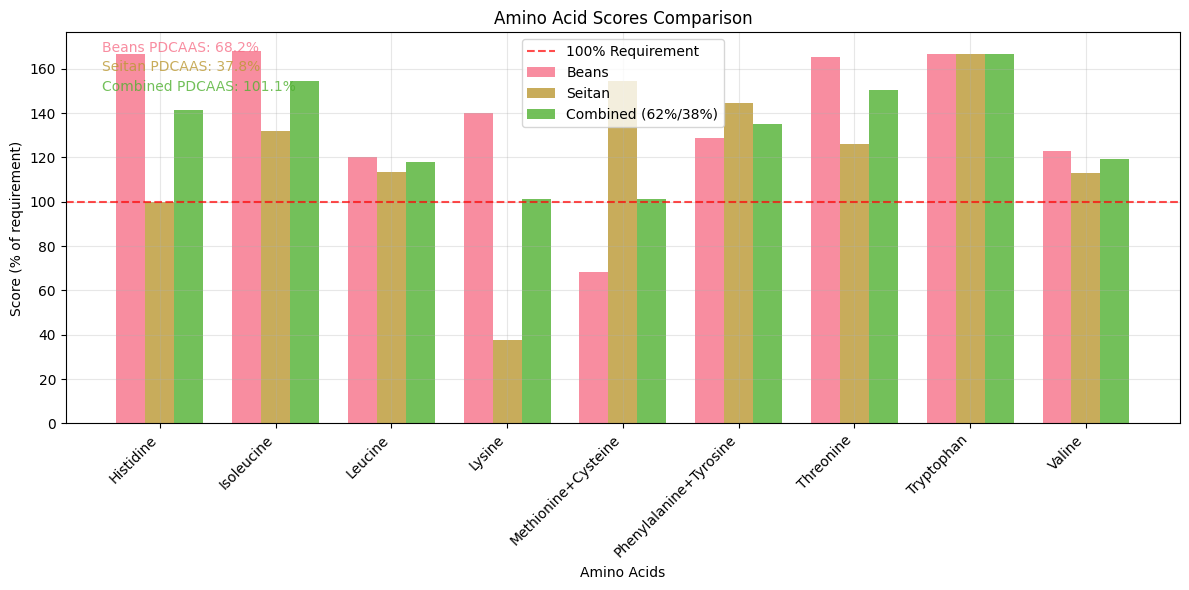

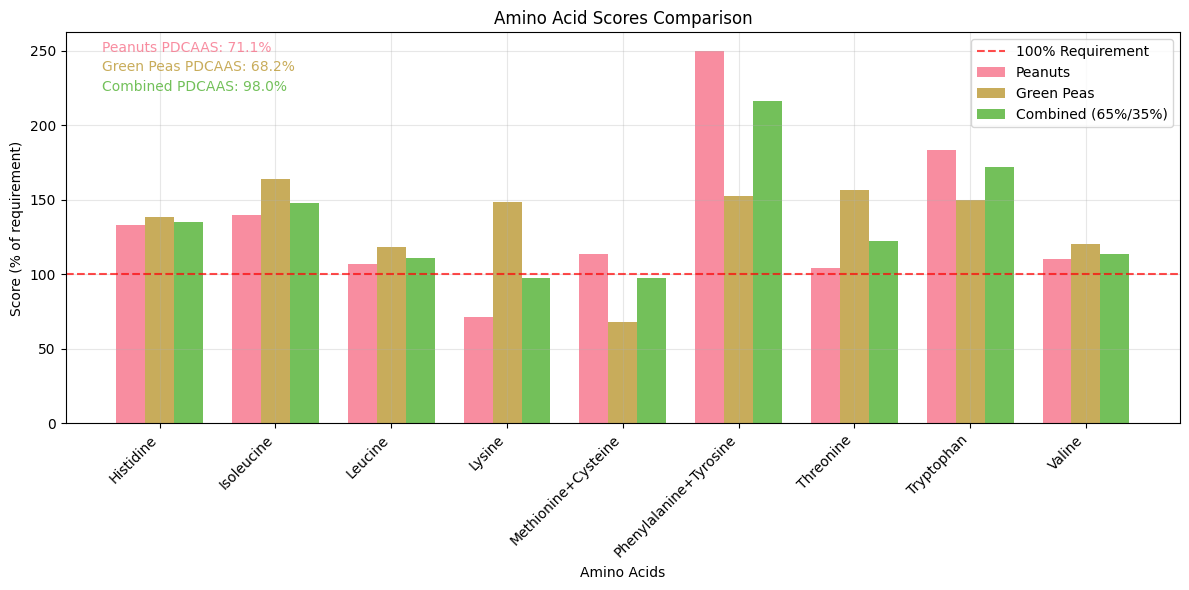

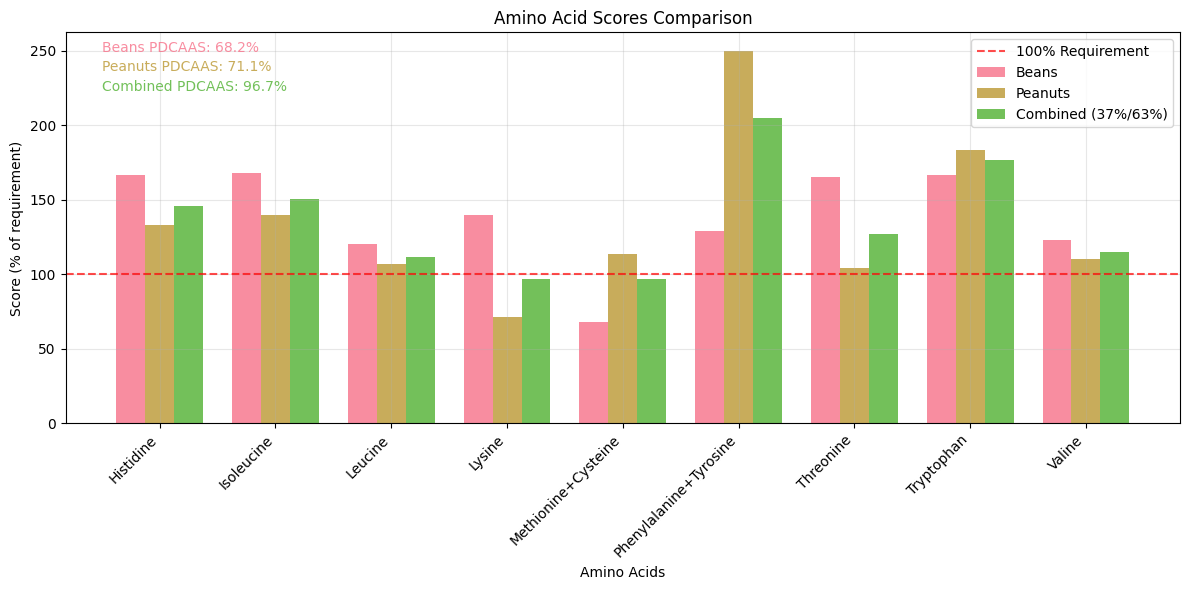

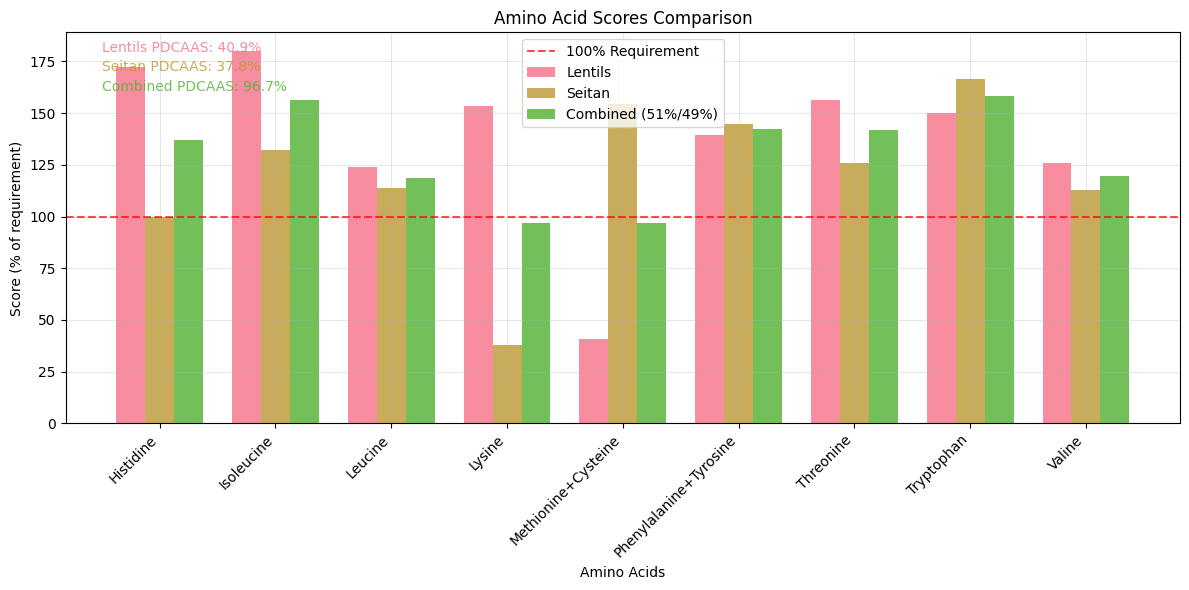

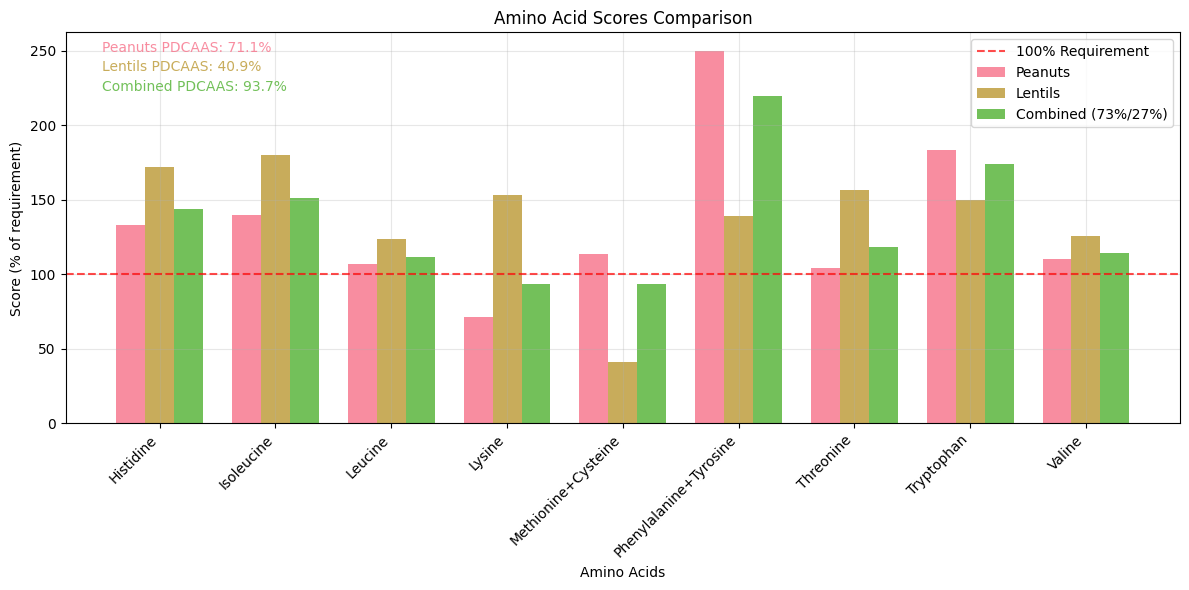

In [16]:
#@title ## 6. Visualization of Best Combination

def plot_combination_comparison(protein1, protein2, ratio1, ratio2):
    """Create visualization comparing individual proteins vs combination"""

    # Calculate combined scores
    combined_scores = []
    for aa in df_reference.index:
        combined_content = (ratio1 * df_proteins.loc[protein1, aa] +
                          ratio2 * df_proteins.loc[protein2, aa])
        combined_score = (combined_content / df_reference[aa]) * 100
        combined_scores.append(combined_score)

    # Calculate PDCAAS scores
    pdcaas1 = min(protein_scores[protein1])
    pdcaas2 = min(protein_scores[protein2])
    combined_pdcaas = min(combined_scores)


    # Create comparison plot
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))


    # Bar chart comparison
    amino_acids = [aa.replace('_', '+') for aa in df_reference.index]
    x = np.arange(len(amino_acids))
    width = 0.25

    rects1 = ax1.bar(x - width, protein_scores[protein1], width, label=protein1, alpha=0.8)
    rects2 = ax1.bar(x, protein_scores[protein2], width, label=protein2, alpha=0.8)
    rects3 = ax1.bar(x + width, combined_scores, width, label=f'Combined ({ratio1:.0%}/{ratio2:.0%})', alpha=0.8)
    ax1.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% Requirement')

    ax1.set_xlabel('Amino Acids')
    ax1.set_ylabel('Score (% of requirement)')
    ax1.set_title('Amino Acid Scores Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(amino_acids, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add PDCAAS text to the plot
    ax1.text(-0.5, max(ax1.get_ylim()) * 0.95, f'{protein1} PDCAAS: {pdcaas1:.1f}%', fontsize=10, color=rects1[0].get_facecolor())
    ax1.text(-0.5, max(ax1.get_ylim()) * 0.90, f'{protein2} PDCAAS: {pdcaas2:.1f}%', fontsize=10, color=rects2[0].get_facecolor())
    ax1.text(-0.5, max(ax1.get_ylim()) * 0.85, f'Combined PDCAAS: {combined_pdcaas:.1f}%', fontsize=10, color=rects3[0].get_facecolor())


    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("VISUALIZING EAA PROFILES OF EACH OPTIMIZED COMBINATION")
print("="*70)

for idx, row in complementary_df_optimized.iterrows():
    protein1, protein2 = row['Protein1'], row['Protein2']
    ratio1, ratio2 = row['Optimal Ratio 1'], row['Optimal Ratio 2']

    plot_combination_comparison(protein1, protein2, ratio1, ratio2)


In [36]:
#@title #7. Combination ratio recomendations

protein_content_per_100g = {
    'Rice': 2.7,
    'Beans': 7.5, # Assumed average for cooked beans (varies by type)
    'Corn': 3.3,
    'Peanuts': 25.8,
    'Quinoa': 4.7,
    'Lentils': 9.0, # Assumed for cooked lentils
    'Seitan': 21.2,
    'Oats': 10.6, # Rolled oats
    'Buckwheat': 13.3,
    'Green Peas': 5.4 # Cooked
}

# Approximate calorie content per 100g of cooked food (calories/100g)
calorie_content_per_100g = {
    'Rice': 130,
    'Beans': 110, # Assumed average for cooked beans
    'Corn': 96,
    'Peanuts': 567,
    'Quinoa': 120,
    'Lentils': 116, # Assumed for cooked lentils
    'Seitan': 106,
    'Oats': 389, # Dry rolled oats
    'Buckwheat': 343, # Dry groats
    'Green Peas': 81 # Cooked
}


print("\nProtein content (grams per 100g food):")
for protein, content in protein_content_per_100g.items():
    print(f"{protein:<25}: {content:>4.1f} g/100g")

print("\nCalorie content (calories per 100g food):")
for protein, content in calorie_content_per_100g.items():
    print(f"{protein:<25}: {content:>4.1f} kcal/100g")


whole_food_ratios = []
protein_calorie_percentages = []

for index, row in complementary_df_optimized.iterrows():
    protein1 = row['Protein1']
    protein2 = row['Protein2']
    optimal_ratio1 = row['Optimal Ratio 1']
    optimal_ratio2 = row['Optimal Ratio 2']

    # Retrieve protein and calorie content per 100g
    protein_content1 = protein_content_per_100g.get(protein1, 0)
    protein_content2 = protein_content_per_100g.get(protein2, 0)
    calorie_content1 = calorie_content_per_100g.get(protein1, 0)
    calorie_content2 = calorie_content_per_100g.get(protein2, 0)


    # Calculate weighted protein content for ratio calculation
    if protein_content1 > 0 and protein_content2 > 0:
        weighted_protein_content1 = optimal_ratio1 * protein_content1
        weighted_protein_content2 = optimal_ratio2 * protein_content2

        if weighted_protein_content1 > 0:
             # To get ratio "X parts Protein1 to 1 part Protein2":  Ratio of Protein1 weight to Protein2 weight
            # (Weight_Protein1 * Protein_g/100g_Protein1) / (Weight_Protein2 * Protein_g/100g_Protein2) = Optimal_Ratio1 / Optimal_Ratio2
            # Weight_Protein1 / Weight_Protein2 = (Optimal_Ratio1 / Optimal_Ratio2) * (Protein_g/100g_Protein2 / Protein_g/100g_Protein1)
            # Weight_Protein1 / Weight_Protein2 = (Optimal_Ratio1 * Protein_g/100g_Protein2) / (Optimal_Ratio2 * Protein_g/100g_Protein1)

            ratio_protein1_to_protein2_by_weight = (optimal_ratio1 * protein_content2) / (optimal_ratio2 * protein_content1)
            whole_food_ratio_str = f"{ratio_protein1_to_protein2_by_weight:.1f} parts {protein1} to 1 part {protein2}"

        else:
            whole_food_ratio_str = f"0 parts {protein1} to 1 part {protein2}" # Should not happen with filtered data
    else:
        whole_food_ratio_str = "Protein content data missing"


    # Calculate percentage of calories from protein
    if protein_content1 > 0 and protein_content2 > 0 and calorie_content1 > 0 and calorie_content2 > 0:
        # Assume we are combining a total of 100g of the mixed whole foods
        # Let w1 and w2 be the weights of protein1 and protein2 such that w1 + w2 = 100
        # The protein contribution from protein1 is w1 * (protein_content1 / 100)
        # The protein contribution from protein2 is w2 * (protein_content2 / 100)
        # The *ratio of protein contributed* should match the optimal ratio:
        # (w1 * protein_content1) / (w2 * protein_content2) = optimal_ratio1 / optimal_ratio2
        # w1 * protein_content1 * optimal_ratio2 = w2 * protein_content2 * optimal_ratio1

        # Let's use the calculated weight ratio: w1 / w2 = ratio_protein1_to_protein2_by_weight
        # w1 = w2 * ratio_protein1_to_protein2_by_weight
        # Substitute into w1 + w2 = 100:
        # (w2 * ratio_protein1_to_protein2_by_weight) + w2 = 100
        # w2 * (ratio_protein1_to_protein2_by_weight + 1) = 100
        # w2 = 100 / (ratio_protein1_to_protein2_by_weight + 1)
        # w1 = 100 - w2

        # If ratio_protein1_to_protein2_by_weight is 0, this implies w1=0, w2=100.
        # If ratio_protein1_to_protein2_by_weight is very large, w2 approaches 0, w1 approaches 100.

        if ratio_protein1_to_protein2_by_weight + 1 > 0: # Avoid division by zero if ratio is -1 (not possible here)
             w2 = 100 / (ratio_protein1_to_protein2_by_weight + 1)
             w1 = 100 - w2
        elif abs(ratio_protein1_to_protein2_by_weight + 1) < 1e-6: # Handle near zero case
             # This case should ideally not be reached with meaningful ratios
             protein_calorie_percentage_str = "Calculation error"
        else: # Handle the case where ratio_protein1_to_protein2_by_weight is negative or very large negative
             protein_calorie_percentage_str = "Calculation error"


        # Calculate total protein and total calories for 100g of the mixed whole foods
        total_protein_in_100g_mix = (w1 * (protein_content1 / 100)) + (w2 * (protein_content2 / 100))
        total_calories_in_100g_mix = (w1 * (calorie_content1 / 100)) + (w2 * (calorie_content2 / 100))

        # Calculate percentage of calories from protein (4 kcal/g protein)
        if total_calories_in_100g_mix > 0:
            protein_calories = total_protein_in_100g_mix * 4
            protein_calorie_percentage = (protein_calories / total_calories_in_100g_mix) * 100
            protein_calorie_percentage_str = f"{protein_calorie_percentage:.1f}%"
        else:
            protein_calorie_percentage_str = "0%" # Avoid division by zero if total calories are 0

    else:
        protein_calorie_percentage_str = "Data missing"


    whole_food_ratios.append(whole_food_ratio_str)
    protein_calorie_percentages.append(protein_calorie_percentage_str)


complementary_df_optimized['Whole Food Ratio by weight (Approximate)'] = whole_food_ratios
complementary_df_optimized['% Calories from Protein (Approximate)'] = protein_calorie_percentages


print("\n" + "="*60)
print("OPTIMIZED PROTEIN COMPLEMENTARITY ANALYSIS WITH WHOLE FOOD RATIOS AND % PROTEIN CALORIES")
print("="*60)
display(complementary_df_optimized[['Protein1', 'Protein2', 'Optimized Combined Score (PDCAAS)', 'Whole Food Ratio by weight (Approximate)', '% Calories from Protein (Approximate)']])


Protein content (grams per 100g food):
Rice                     :  2.7 g/100g
Beans                    :  7.5 g/100g
Corn                     :  3.3 g/100g
Peanuts                  : 25.8 g/100g
Quinoa                   :  4.7 g/100g
Lentils                  :  9.0 g/100g
Seitan                   : 21.2 g/100g
Oats                     : 10.6 g/100g
Buckwheat                : 13.3 g/100g
Green Peas               :  5.4 g/100g

Calorie content (calories per 100g food):
Rice                     : 130.0 kcal/100g
Beans                    : 110.0 kcal/100g
Corn                     : 96.0 kcal/100g
Peanuts                  : 567.0 kcal/100g
Quinoa                   : 120.0 kcal/100g
Lentils                  : 116.0 kcal/100g
Seitan                   : 106.0 kcal/100g
Oats                     : 389.0 kcal/100g
Buckwheat                : 343.0 kcal/100g
Green Peas               : 81.0 kcal/100g

OPTIMIZED PROTEIN COMPLEMENTARITY ANALYSIS WITH WHOLE FOOD RATIOS AND % PROTEIN CALORIES


,Protein1,Protein2,Optimized Combined Score (PDCAAS),Whole Food Ratio by weight (Approximate),% Calories from Protein (Approximate)
0,Lentils,Buckwheat,117.981072,0.3 parts Lentils to 1 part Buckwheat,16.8%
1,Beans,Buckwheat,117.701148,0.5 parts Beans to 1 part Buckwheat,17.2%
2,Oats,Buckwheat,117.691776,0.4 parts Oats to 1 part Buckwheat,14.2%
3,Buckwheat,Green Peas,117.334905,1.4 parts Buckwheat to 1 part Green Peas,17.1%
4,Quinoa,Lentils,116.328185,13.2 parts Quinoa to 1 part Lentils,16.7%
5,Beans,Quinoa,116.206475,0.1 parts Beans to 1 part Quinoa,17.0%
6,Quinoa,Green Peas,115.906287,4.8 parts Quinoa to 1 part Green Peas,17.0%
7,Corn,Green Peas,110.669160,1.0 parts Corn to 1 part Green Peas,19.7%
8,Rice,Green Peas,110.023040,1.7 parts Rice to 1 part Green Peas,13.2%
9,Beans,Corn,107.613466,0.8 parts Beans to 1 part Corn,20.3%
